# Precision-landing of a Parrot drone 

This tutorial describes the precision control of a Parrot drone to perform a precision landing, the drone is roughly 30\*30cm and should land in a 60\*60cm area inside a box.

# System description

The drone is a Parrot drone, controlled either via speed or via position command (performed using its internal controller). 
The drone starts a few meters above and a few meters away from the box. 
Initial strategy was to perform image recognition to locate the box, actual solution was to use a QR-code to perform quick and precise recognition of the box's center:

![drone real](images/drone_real-min.jpg)

The difficulty lies in the fact that the computation is made on an external PC being subject to communication delays when sending commands or receiving data from the drone. 
These data are composed of the drone's odometry and video flux from its camera.


![simple diagram](images/simple_diagramm.jpg)


# 1. QR code detection

## QR code selection

In this project, we propose to detect the target based on one of multiple QR-codes attached to it. To do so, we will leverage open source Aruco markers which can be detected by cv2 library in ~10ms (See [Open CV](https://docs.opencv.org/4.x/d5/dae/tutorial_aruco_detection.html) documentation). Each marker is member of a dictionary set and is storing an ID (See [Aruco generator](https://chev.me/arucogen/)) which allow recognizing them precisely.

![qr example](images/qr_example.svg)

### QR code size

Choosing the QR code size has to be made upon following the following parameters :
- Drone's range of altitude : 0 to 10 m height
- Drone's camera Field Of View (FOV) : 68° in video mode
- Minimum number of pixels for Aruco detection : This is a bit unclear, [forums](https://github.com/zsiki/Find-GCP#:~:text=The%203x3%20or%204x4%20ArUco%20markers%20on%20the%20image%20should,50%20m%20above%20the%20ground.) state 20 to 100 pixels of width for good recognition
- Camera resolution : 1920*1080 pixels

For instance, if drone is at 10 meters, it sees

$$
\text{Scene width} = 2 \cdot \tan\left(\frac{68^\circ}{2}\right) \cdot 10 \approx 13.49,\text{m}
$$

That means **13.49 meters are projected into 1920 pixels**. Said differently, the drone sees roughly the same width as its altitude.

$$
\text{Pixel size} = \frac{13.49,\text{m}}{1920} \approx 7.02,\text{mm/pixel}$$


To be reliably detected, a marker should be at least **20 pixels wide**, more for robust detection and pose estimation:

**Minimum (20 px)**:
  $$
  20 \times 7.02 = 140.4,\text{mm} \approx \textbf{14 cm}
  $$

**Optimal (100 px)**:
$$
100 \times 7.02 = 702,\text{mm} \approx \textbf{70.2 cm}
$$


From this small example, we can already grasp the fact that it is really hard to use the same QR-code for all the landing process. Indeed, a 0.7m is optimal for higher heights, but won't be appropriate when the drone is below one meter.
Final choice was thus to select not one but three QR-codes of complementary sizes to cover all the required altitude range:

**✅ Conclusion (Full HD at 10 m):**

| Detection         | ID | Marker size | Approximate altitude range |
|-------------------|----|-------------|----------------------------|
| **First phase**   | 3  | 27.5 cm     | > 5 m                      |
| **Descent phase** | 2  | 15 cm       | 1 to 5 m                   |
| **Target locking**| 1  | 5 cm        | <1 m                       |





## QR code recognition

## Relative positioning based on markers only

Here’s a clean **Markdown explanation** of your QR code computation with paragraph-style descriptions and included equations:


This system estimates the position of a reference QR code (ID = 0) using detections of one or more other QR codes in the environment. The method combines geometric projection based on known distances between QR codes with distance estimation from the QR code’s apparent size in the camera image.

---

**1. Estimating the Reference QR Code Position**

When a QR code is detected, its center coordinates ($(x, y)$) and rotation angle ($\theta$) are available from cv2. If the detected QR code is **QR 0 itself**, its position is used directly. Otherwise, the position of QR 0 is computed by projecting backward along the line defined by the detected QR code’s orientation and the known distance (d) between the QR codes:

$$
\Delta x = -d \cos(\theta), \quad \Delta y = -d \sin(\theta)
$$

$$
x_0 = y_{\text{detected}} + \Delta x, \quad y_0 = x_{\text{detected}} + \Delta y
$$

Here, the coordinates are swapped to align with the reference frame convention used in the system. This projection allows the system to estimate the position of QR 0 even when it is not directly visible.

**2. Estimating Distance from QR Code Size**

The distance from the camera to a detected QR code is estimated using the apparent size of the QR in the image. Let (A_{\text{px}}) be the pixel area of the QR code, ($W_{\text{real}}$) its real-world width, ($W_{\text{img}}$) the image width in pixels, and ($\text{FOV}$) the horizontal field of view of the camera.

First, compute the QR code width in pixels:

$$
W_{\text{px}} = \sqrt{A_{\text{px}}}
$$

The camera focal length in pixels is derived from the image width and FOV:

$$
f = \frac{W_{\text{img}}}{2 \tan(\text{FOV} / 2)}
$$

Finally, the distance to the QR code is estimated using the pinhole camera model:

$$
D = \frac{W_{\text{real}} \cdot f}{W_{\text{px}}}
$$

This provides the distance in the same units as the QR code width (converted to meters if necessary).

---

**3. Handling Multiple QR Codes of Different Sizes**

The system can detect multiple QR codes with different physical sizes. A dictionary defines the real-world sizes and relative distances between QR codes:

```python
QR_code_sizes = {"0": 5.0, "1": 15, "2": 27.5, "02": 17.5, "01": -11}  # cm
```

* Each QR code can have a unique physical size.
* Relative distances between QR codes are encoded to allow projection even when QR 0 is not visible.
* This combination ensures the system works robustly for multiple QR codes, different sizes, and partial occlusions.

---


By combining **geometric projection** and **visual scaling**, the system can:

* Estimate the position of a reference QR code even if it is not detected.
* Handle multiple QR codes of varying sizes.
* Calculate distances accurately using the camera FOV and QR code pixel measurements.

This approach makes the QR-based localization robust, flexible, and suitable for real-time tracking scenarios.

### Results 

Following example show the recognition leveraging the 3 QR codes to estimate the relative position of the drone to the QR code :

![qr](images/gif_demo.gif)

### Note : Managing uncertainty

We could do a bit better than what have been exposed by estimating the position with all available QR codes and by fusing it with a weighted average approach. This would allow to always use the maximum amount of information available.

### Note :  Video flux

Video flux is treated in RTSP using gstreamer and cv2. Image resolution has been reduced to optimize latency and color set to grayscale.

# 2. Drone control in ideal case

Let's start to design of our controller in an ideal case, i.e. the controller is having perfect information from the environment, perfect camera reading and perfect communication.

## The basics : PID control

We will control our drone based on the relative position with the target, which is :
$$
(x_{drone}-x_{target},y_{drone}-y_{target},z_{drone}-z_{target},\theta_{drone}-\theta_{target})
$$

all expressed in meter.

All dimensions : x, y, z and theta can be treated with a dedicated PID of the form :

$$
u(t) = K_p \, e(t) + K_i \int_0^t e(\tau) \, d\tau + K_d \frac{de}{dt},

where:
- u(t) is the command in cm in a direction,
- $K_p$ is the proportional gain,
- $K_i$ is the integral gain,
- $K_d$ is the derivative gain,
- e(t) is the error between the target and the drone.
$$

For sake of simplicity and visual behavior, z-axis will be treated with a constant descent speed which helps to avoid small oscillations. 

## Drone model
### Linear model

Parrot Drone has position or stick control modes. Position control ensures the drone reaches the correct position, but creates a-coup, where stick is giving a constant speed to the motors, resulting in a drone speed that depends on the environment.

Mathematically, a stick-control drone can be seen as "pure-integrator", it integrates the commands to give drone's position :

$$
x(t) = \int_0^t u(\tau) d\tau 
$$

The reality is a bit more complex but this will be enough to grasp the following examples.

### Landing phase

Finally, Parrot Drones can't be landed using z-command only, it has to be sent to LANDING-MODE, resulting in a direct descent to the ground, without $x/y/\theta$ control. The mode is activated in the simulation when the drone is below 40cm. Moreover, this landing phase in not precise due to the fact that air from drone's rotors is pushed back to itself when approaching the ground resulting in jitterings. These are simulated by adding a random normal noise to the speed vector during the landing phase :

$$
\tilde{u(k)} = u(k) + \sim \mathcal{N}(0, \sigma^2)
$$

We set $\sigma =0.2$ meaning the drone can suffer from high, non-negligible variations during this phase. 

## First example

PID will take the shortest x/y path and generate straight lines in absence of yaw errors, z speed is set to constant -0.2m/s. The effect of the LANDING-MODE activated at 40cm above the ground shows the difficulty to reach the center at the right time.



In [ ]:
from DroneEnv import DroneLandingEnv
from PIDCon import PIDController
from PID_run import run_pid_simulation

sim_dt = 0.1         # simulation step (10 Hz)
env = DroneLandingEnv(render_mode=None, dt=sim_dt)
controller_dt = 0.1  # controller step (1 Hz)

pid = PIDController(Kp=[1.0,1.0,1.0, 0.0], 
                    Ki=[0.0,0.0,0.0,0.0], 
                    Kd=[0.0,0.0,0.0,0.0], 
                    dt=controller_dt, 
                    integral_limit=0.5, 
                    z_fixed_speed= -0.2)

states, target = run_pid_simulation(
        env = env,
        pid = pid,
        init_mode='fixed',
        plot=True)


A small integral contributions helps to reach the center with more precision (up to the precision of the drone landing sequence):

In [ ]:
sim_dt = 0.1         # simulation step (10 Hz)
env = DroneLandingEnv(render_mode=None, dt=sim_dt)
controller_dt = 0.1  # controller step (1 Hz)

pid = PIDController(Kp=[2.0,2.0,2.0, 0.0], Ki=[0.1,0.1,0.0,0.0], Kd=[0.0,0.0,0.0,0.0], dt=controller_dt, integral_limit=0.5, z_fixed_speed= -0.2)

states, target = run_pid_simulation(env = env, pid = pid, init_mode='fixed', plot=True)


## How to handle yaw

Previous example was assuming correct yaw. When using a PID for yaw as well, we obtain more complex, less straightforward trajectory, as the drone is rotating while moving.

In [ ]:
sim_dt = 0.1         # simulation step (10 Hz)
env = DroneLandingEnv(render_mode=None, dt=sim_dt)
controller_dt = 0.1  # controller step (1 Hz)

pid = PIDController(Kp=[2.0,2.0,2.0, 2.0], Ki=[0.1,0.1,0.0,0.2], Kd=[0.0,0.0,0.0,0.0], dt=controller_dt, integral_limit=0.5, z_fixed_speed= -0.2)

states, target = run_pid_simulation(env = env, pid = pid, init_mode='fixed', plot=True, init_pos = [2.0,2.0,2.0,2.0])

## Tuning with delay

Even in the ideal case, there is something we forgot, we did not take into account that the there is a computation+communication delay between the drone and the computer. This means that the controller is at fixed lower frequency than the drone (10 Hz simulation here). Following 

In [ ]:
sim_dt = 0.1         # simulation step (10 Hz)
env = DroneLandingEnv(render_mode=None, dt=sim_dt)
controller_dt = 1.0  # controller step (1 Hz)

pid = PIDController(Kp=[2.0,2.0,2.0, 2.0], Ki=[0.1,0.1,0.0,0.2], Kd=[0.0,0.0,0.0,0.0], dt=controller_dt, integral_limit=0.5, z_fixed_speed= -0.2)

states, target = run_pid_simulation(env = env, pid = pid, init_mode='fixed', plot=True, init_pos = [2.0,2.0,2.0,2.0])

Delay introduction shows 2 things:
- It makes the drone turning around itself which causes a deviation from the target
- It makes the drone oscillates around the target in every direction

The drone is bounded-stable, no more asymptotically stable.
To solve the first issue, we will treat the yaw axis in 2-steps:
- No yaw movement if the drone is more than 0.3m away of the target
- Yaw + x/y axis if the drone is 0.3m close to the target

In [ ]:
sim_dt = 0.1         # simulation step (10 Hz)
env = DroneLandingEnv(render_mode=None, dt=sim_dt)
controller_dt = 1.0  # controller step (1 Hz)

pid = PIDController(Kp=[2.0,2.0,2.0, 2.0], Ki=[0.1,0.1,0.1,0.2], Kd=[0.0,0.0,0.0,0.0], dt=controller_dt, integral_limit=0.5, z_fixed_speed= -0.2, yaw_2_steps =True)

states, target = run_pid_simulation(env = env, pid = pid, init_mode='fixed', plot=True, init_pos = [2.0,2.0,2.0,2.0])



Second issue can be treated with smoother control (lower coefficients) when being closer to the target: coefficients are divided by 2 when being above the target.


In [ ]:
sim_dt = 0.1         # simulation step (10 Hz)
env = DroneLandingEnv(render_mode=None, dt=sim_dt)
controller_dt = 1.0  # controller step (1 Hz)

pid = PIDController(Kp=[2.0,2.0,2.0, 1.0], Ki=[0.1,0.1,0.1,0.2], Kd=[0.0,0.0,0.0,0.0], dt=controller_dt, integral_limit=0.5, z_fixed_speed= -0.2, yaw_2_steps =True, finer_gains=True)

states, target = run_pid_simulation(env = env, pid = pid, init_mode='fixed', plot=True, init_pos = [2.0,2.0,2.0,2.0])

# 3. Drone control in real situation - Study of the impact of delay and losses

## Well that's done, what could go wrong in real life?

![complex diagram](images/complex_diagram.jpg)

## Noise

As with every sensing devices, our control loop is subject to various noises, among which :
- GPS accuracy
- Accelerometer and gyroscope noises
- Camera pixel accuracy

All data coming from drone sensors are fused using a Kalman filter in an optimal way. However, GPS can be disturbed easily, especially when being close to the ground. And relying on the homemade drone estimation that we don't control (especially on altitude estimation) can be risky for our target level of precision.
During the project, decision was taken to focus on the camera for directly estimating the relative position to the target. 
Camera is not really subject to noise, but to model the pixel's accuracy, small noise is added before the controller, of the following form :

We model sensor noise by applying a multiplicative Gaussian perturbation on the error signal. For each controller step $(k)$, the noisy error is

$$
\tilde{e}_k = e_k \cdot \left( 1 + \eta_k \right),
$$

with

$$
\eta_k \sim \mathcal{N}(0, \sigma^2),
$$

where

* $e_k \in \mathbb{R}^4$ is the true error vector (position and yaw),
* $\tilde{e}_k$ is the noisy estimate of the error,
* $\sigma $ is the standard deviation of the noise (here ($\sigma = 0.01$)).

This corresponds to an estimation precision of a few percent, which is too small to significantly degrade controller performance, but still reflects the imperfect sensing conditions.



In [ ]:
from PID_run import run_noisy_pid_simulation
sim_dt = 0.1         # simulation step (10 Hz)
env = DroneLandingEnv(render_mode=None, dt=sim_dt)
controller_dt = 1.0  # controller step (1 Hz)

pid = PIDController(Kp=[2.0,2.0,2.0, 2.0], Ki=[0.1,0.1,0.0,0.2], Kd=[0.0,0.0,0.0,0.0], dt=controller_dt, integral_limit=0.5, z_fixed_speed= -0.2, yaw_2_steps =True, finer_gains=True)

noise_std = 0.02

states, target = run_noisy_pid_simulation(env = env, pid = pid, init_mode='fixed', plot=True, init_pos = [2.0,2.0,2.0,2.0], max_delay_steps = 0, p_loss = 0, wind_std = [0.0, 0.0, 0.0, 0.0], noise_std = noise_std)


## Wind effect

Wind is off course the unknown component of our problem. It could be theoretically roughly estimated using drone's sensors but rather than relying on a potential estimation of the wind, we rather focus on making our drone's controller robust to disturbances. To do so, we implement the following 2-fold process for wind simulation. First, for each experiment we draw a general wind vector which will stay in a fixed direction and magnitude. Then, at each timestep, we consider a small variation around this wind vector to model uncertainty. 


We model the wind as a combination of a fixed global component and a small random fluctuation.

First, a constant wind vector is uniformly drawn at the beginning of each experiment:

$$
w_0 \sim \mathcal{U}([min,max]),
$$

where ($w_0 \in \mathbb{R}^3$) represents the nominal wind in ($(x,y,z)$) directions.

Then, at each timestep $(k)$, the effective wind is modeled as:

$$
w_k = w_0 + \delta_k, \qquad \delta_k \sim \mathcal{N}(0, \sigma_w^2 I),
$$

where ($\delta_k$) represents zero-mean Gaussian noise with standard deviation ($ \sigma_w $ ).

The drone’s velocity update is then perturbed as

$$
v_{k+1} = u_k +  w_k,
$$

with ($u_k$) the commanded velocity in the world frame and ($\Delta t$) the simulation timestep.


In [ ]:
from PID_run import run_noisy_pid_simulation
sim_dt = 0.1         # simulation step (10 Hz)
env = DroneLandingEnv(render_mode=None, dt=sim_dt)
controller_dt = 1.0  # controller step (1 Hz)

pid = PIDController(Kp=[2.0,2.0,2.0, 1.0], Ki=[0.1,0.1,0.0,0.2], Kd=[0.0,0.0,0.0,0.0], dt=controller_dt, integral_limit=0.5, z_fixed_speed= -0.2, yaw_2_steps =True, finer_gains=True)

# Delay and packet loss parameters
wind_std=[0.2, 0.2, 0.2, 0.2]
noise_std = 0.02

states, target = run_noisy_pid_simulation(env = env, pid = pid, init_mode='fixed', plot=True, init_pos = [2.0,2.0,2.0,2.0], max_delay_steps = 0, p_loss = 0, wind_std = wind_std, noise_std = noise_std)


In [ ]:
sim_dt = 0.1         # simulation step (10 Hz)
env = DroneLandingEnv(render_mode=None, dt=sim_dt)
controller_dt = 1.0  # controller step (1 Hz)

pid = PIDController(Kp=[2.0,2.0,2.0, 2.0], Ki=[0.1,0.1,0.0,0.2], Kd=[0.0,0.0,0.0,0.0], dt=controller_dt, integral_limit=0.5, z_fixed_speed= -0.2, yaw_2_steps =True, finer_gains=True)

# Delay and packet loss parameters
max_delay_steps = 3  # 1 or 2 sim steps additional delay
p_loss = 0.15      # packet loss probability
wind_std=[0.1, 0.1, 0.1, 0.01]
noise_std = 0.02

states, target = run_noisy_pid_simulation(env = env, pid = pid, init_mode='fixed', plot=True, init_pos = [2.0,2.0,2.0,2.0], max_delay_steps = max_delay_steps, p_loss = p_loss, wind_std = wind_std, noise_std = noise_std)




## Packet loss

Having a wireless communication implies being subject to various potential issues, among them, the risk of packet loss is the risk of losing one or multiple information. This is particularly detrimental when the communication frequency is low, because losing one packet means waiting twice the amount of time before getting an information. In different communication protocol, the risk of packet loss is in general reduced when the latency is increased, because more security is taken to ensure the message is delivered, even if it arrives later. From experiments, packet loss is particularly likely when the drone is close to the ground, because the antenna is partially targeting to the ground. 
In our simulation, we model the risk of packet loss in a Bernoulli experiment way, at each controller step, there is a $p$ risk that the information is dropped. This $p$ probability is fixed despite the fact that the risk is a higher when drone altitude is lower.

$$
X_k \sim \text{Bernoulli}(1-p),
$$

where
($X_k = 1$) means the control packet is successfully received,
($X_k = 0$) means the packet is lost,
($p \in [0,1]$) is the probability of packet loss.
Thus, the applied control at time ($k$) is

$$
u_k^{\text{applied}} = X_k , u_k + (1 - X_k) , u_{k-1}^{\text{applied}},
$$

meaning the new control ($u_k$) is applied if the packet is received, otherwise the last valid control is reused.






In [ ]:
sim_dt = 0.1         # simulation step (10 Hz)
env = DroneLandingEnv(render_mode=None, dt=sim_dt)
controller_dt = 1.0  # controller step (1 Hz)

pid = PIDController(Kp=[2.0,2.0,2.0, 2.0], Ki=[0.1,0.1,0.0,0.2], Kd=[0.0,0.0,0.0,0.0], dt=controller_dt, integral_limit=0.5, z_fixed_speed= -0.2, yaw_2_steps =True, finer_gains=True)

# Delay and packet loss parameters
p_loss = 0.3      # packet loss probability
max_delay_steps = 0  # 1 or 2 sim steps additional delay
wind_std=[0.1, 0.1, 0.1, 0.01]
noise_std = 0.02

states, target = run_noisy_pid_simulation(env = env, pid = pid, init_mode='fixed', plot=True, init_pos = [2.0,2.0,2.0,2.0], max_delay_steps = max_delay_steps, p_loss = p_loss, wind_std = wind_std, noise_std = noise_std)


## Non-fixed delays

Finally, we add to the simulation a last type of disturbance in the control loop : non-fixed delays. Indeed, because of the amount of information that are being transferred (live video flux), the evolution of the drone position and orientation, communication can suffer from a non-fixed delay of communication. Previously, fixed-delay was taken into account by considering different running frequencies between the drone simulation (10 Hz) and the controller (1 Hz), meaning that the total time of sending - compute - sending back was 1s, or that one side of communication takes roughly 0.5s . Now, we consider that these times might be non-constant, to do so, we consider that an action theoretically received at time $t$ can actually be received only at time: 

$$
t+ m~\delta t
$$ 

where $\delta t$ is a simulation step (0.1s) and $m$ a random integer in [0, max_delay_in_timesteps]. From the command point of view, it gives:

$$
u^{\mathrm{apl}}_k =
\begin{cases}
u^{\mathrm{apl}}_{k-1}, & \text{if no new packet arrives at } k, \\
u_j, & \text{if packet } j \text{ arrives at } k.
\end{cases}
$$

where $k$ is a simulation step.

In [ ]:
sim_dt = 0.1         # simulation step (10 Hz)

# Delay and packet loss parameters
max_delay_steps = 3  # 1 or 2 sim steps additional delay
p_loss = 0.15      # packet loss probability
wind_std=[0.1, 0.1, 0.1, 0.01]
noise_std = 0.02

stables = []

for i in range(0,3):
    env = DroneLandingEnv(render_mode=None, dt=sim_dt)

    pid = PIDController(Kp=[2.0,2.0,2.0, 2.0], Ki=[0.1,0.1,0.0,0.2], Kd=[0.0,0.0,0.0,0.0], dt=controller_dt, integral_limit=0.5, z_fixed_speed= -0.2, yaw_2_steps =True, finer_gains=True)
    states, target = run_noisy_pid_simulation(env = env, pid = pid, init_mode='random', plot=True, max_delay_steps = max_delay_steps, p_loss = p_loss, wind_std = wind_std, noise_std = noise_std)
    
    tol =0.3
    x, y, z, theta = states[:,0], states[:,1], states[:,2], states[:,3]
    # Final horizontal error
    dx = abs(x[-1] - target[0])
    dy = abs(y[-1] - target[1])
    stable = (dx < tol) and (dy < tol)
    stables.append(stable)



## Stability analysis 

### Stability criterion

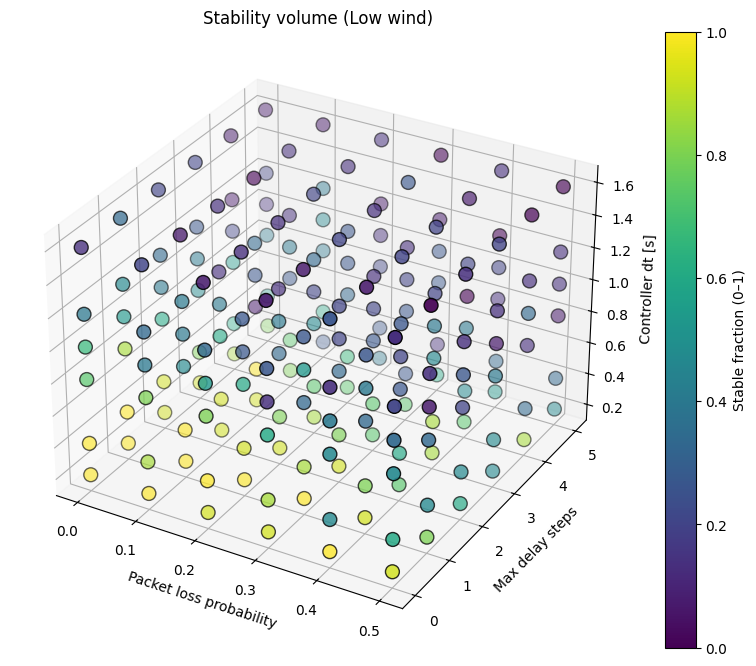

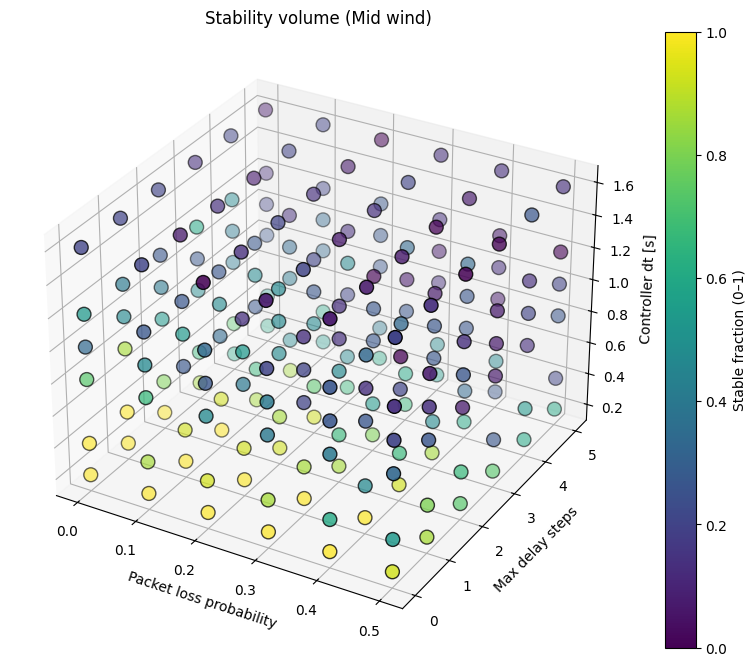

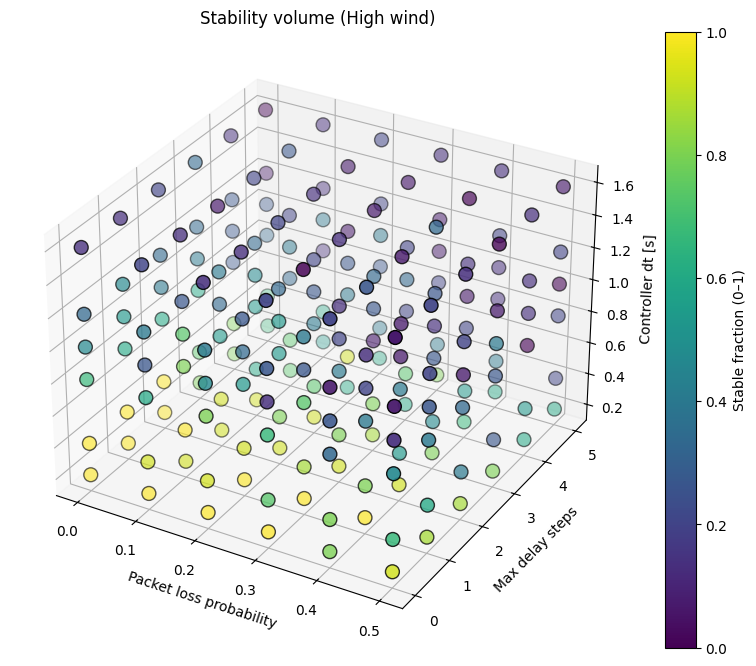

In [1]:
from PidEval import sweep_parameters, plot_stability_volume

noise_std = 0.02

# Three wind scenarios
wind_scenarios = {
    "Low wind":  [0.0, 0.0, 0.0, 0.0],
    "Mid wind":  [0.05, 0.05, 0.05, 0.01],
    "High wind": [0.1, 0.1, 0.1, 0.02],
}

for label, wind_std in wind_scenarios.items():
    results = sweep_parameters(wind_std, noise_std)
    plot_stability_volume(results, title=f"Stability volume ({label})")



# Conclusion